In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import utils
import os

In [2]:
CLEANED_TEST_FILE = '../data/test_data.txt'
CLEANED_TRAIN_FILE = '../data/train_data.txt'
SAVE_MODEL_PATH_ENCODER = '../trained_models/encoder_model.h5'
SAVE_MODEL_PATH_DECODER = '../trained_models/decoder_model.h5'
NUM_ELEMENTS = 50000

In [ ]:
# Check if files exist, if not run clean_datasets.ipynb
if not "test_data.txt" in os.listdir('../data/') or not "train_data.txt" in os.listdir('../data/'):
    print("Run clean_datasets.ipynb before continuing")
else:
    print("Ready to go!")

In [3]:


articles = []
headlines = []

# Get training and test data from files
with open(CLEANED_TRAIN_FILE,'r', encoding="utf-8") as file:
    data = file.readlines()
    for line in data:
        line = line.split(' TL;DR ')
        articles.append(line[0].lower().strip())
        headlines.append(line[1].lower().strip())    
with open(CLEANED_TEST_FILE,'r', encoding="utf-8") as file:
    data = file.readlines()
    for line in data:
        line = line.split(' TL;DR ')
        articles.append(line[0].lower().strip())
        headlines.append(line[1].lower().strip())

articles = articles[0:NUM_ELEMENTS]
headlines = headlines[0:NUM_ELEMENTS]
print(articles[0])
print(headlines[0])
print(len(articles))
print(len(headlines))
pre_proc = pd.DataFrame({'text': articles, 'summary': headlines}, columns=['text', 'summary'])

at this week’s facebook f8 conference in san jose, mark   zuckerberg doubled down on his  first revealed   in april 2016. ” ”   here’s the current version of that roadmap, revealed by   zuckerberg this week:  ” ’  ’ ”   basically, zuckerberg’s uses this roadmap to   demonstrate facebook’s   game plan in action:   first, you take the time to develop a neat     technology. then you build a product base
the smartphone is eventually going to die — this is mark zuckerberg’s crazy vision for what comes next
49999
49999


In [4]:
print(pre_proc.head(2))

                                                text  \
0  at this week’s facebook f8 conference in san j...   
1  ross douthat of the new york times has admitte...   

                                             summary  
0  the smartphone is eventually going to die — th...  
1  douthat: hillary offered nothing to #nevertrum...  


In [5]:
brief_cleaning_text = utils.text_strip(pre_proc['text'])
brief_cleaning_summary = utils.text_strip(pre_proc['summary'])

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(brief_cleaning_text, batch_size=5000)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning_summary, batch_size=5000)]

In [7]:
print(text[0])
print(summary[0])

at this week’s facebook f8 conference in san jose mark zuckerberg doubled down on his first revealed in april 2016 here’s the current version of that roadmap revealed by zuckerberg this week ” basically zuckerberg’s uses this roadmap to demonstrate facebook’s game plan in action first you take the time to develop neat technology then you build product base
_START_ the smartphone is eventually going to die this is mark zuckerberg’s crazy vision for what comes next _END_


In [8]:
pre_proc['cleaned_text'] = pd.Series(text)
pre_proc['cleaned_summary'] = pd.Series(summary)

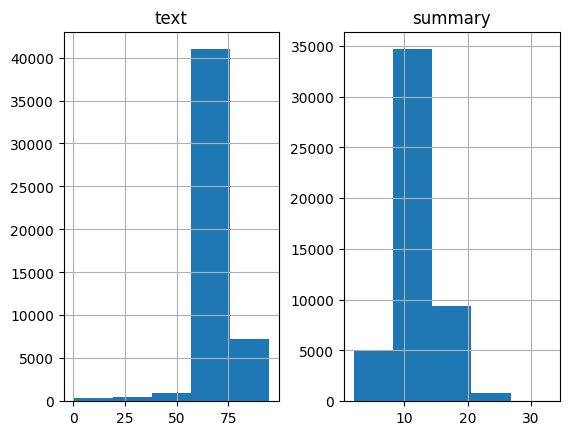

In [9]:
text_count = []
summary_count = []

for sent in pre_proc['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre_proc['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [10]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre_proc['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre_proc['cleaned_text']))

# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

1.0


In [11]:
cleaned_text = np.array(pre_proc['cleaned_text'])
cleaned_summary= np.array(pre_proc['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})
post_pre.head(2)

,text,summary
0,ross douthat of the new york times has admitte...,_START_ douthat hillary offered nothing to #ne...
1,president donald trump that removed the nation...,_START_ trump just made an unprecedented ’radi...


In [12]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x + ' eostok')
post_pre.to_csv('../data/ed_cleaned_data.csv')
print(post_pre)

                                                    text  \
0      ross douthat of the new york times has admitte...   
1      president donald trump that removed the nation...   
2      cnn airplane carrying two seriously ill patien...   
3      president trump stood by his campaign promise ...   
4      assuming senate democrats cannot torpedo his c...   
...                                                  ...   
42843  cnn florida man tried to set convenience store...   
42844  since 2009 rapper corey miller has been servin...   
42845  the battle between senator ted cruz and donald...   
42846  cnn donald trump has had terrible few days he ...   
42847  berlin ap onlookers apparently shouted “jump b...   

                                                 summary  
0      sostok _START_ douthat hillary offered nothing...  
1      sostok _START_ trump just made an unprecedente...  
2      sostok _START_ risky flight from south pole ar...  
3      sostok _START_ trump tells reporters

In [13]:
post_pre = pd.read_csv('../data/ed_cleaned_data.csv')
post_pre = post_pre.loc[:, ~post_pre.columns.str.contains('^Unnamed')]
post_pre = post_pre.fillna("")

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre['text']),
    np.array(post_pre['summary']),
    test_size=0.1,
    shuffle=False
)

In [14]:
art_tokenizer, x_tr, x_val = utils.build_tokenizer(x_tr, x_val, max_text_len)
head_tokenizer, y_tr, y_val = utils.build_tokenizer(y_tr, y_val, max_summary_len)

# Size of vocabulary (+1 for padding token)
art_voc = art_tokenizer.num_words + 1
head_voc = head_tokenizer.num_words + 1
print(art_voc)
print(head_voc)

% of rare words in vocabulary:  45.7757871354066
% of rare words in vocabulary:  48.27797149324035
44916
16911


In [15]:
def remove_empty(x_data, y_data):
    # Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
    ind = []

    for i in range(len(y_data)):
        cnt = 0
        for j in y_data[i]:
            if j != 0:
                cnt = cnt + 1
        if cnt == 2:
            ind.append(i)

    y_data = np.delete(y_tr, ind, axis=0)
    x_data = np.delete(x_tr, ind, axis=0)
    return x_data, y_data

In [16]:
x_tr, y_tr = remove_empty(x_tr, y_tr)
x_val, y_val = remove_empty(x_val, y_val)
assert(len(x_tr) == len(y_tr))
assert(len(x_val) == len(y_val))

In [17]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(art_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(head_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(head_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     8983200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [19]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=8,
    callbacks=[es],
    batch_size=64,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

Epoch 1/8
603/603 [==============================] - 1016s 2s/step - loss: 5.2516 - val_loss: 4.9295
Epoch 2/8
603/603 [==============================] - 980s 2s/step - loss: 4.9128 - val_loss: 4.7690
Epoch 3/8
603/603 [==============================] - 945s 2s/step - loss: 4.7598 - val_loss: 4.6057
Epoch 4/8
603/603 [==============================] - 946s 2s/step - loss: 4.6173 - val_loss: 4.4655
Epoch 5/8
603/603 [==============================] - 938s 2s/step - loss: 4.5068 - val_loss: 4.3568
Epoch 6/8
603/603 [==============================] - 882s 1s/step - loss: 4.4117 - val_loss: 4.2704
Epoch 7/8
603/603 [==============================] - 887s 1s/step - loss: 4.3240 - val_loss: 4.1629
Epoch 8/8
603/603 [==============================] - 883s 1s/step - loss: 4.2519 - val_loss: 4.0792


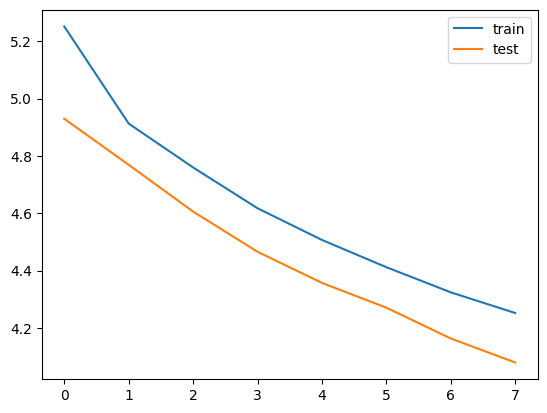

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
reverse_target_word_index = head_tokenizer.index_word
reverse_source_word_index = art_tokenizer.index_word
target_word_index = head_tokenizer.word_index

In [22]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])
decoder_model.save("../trained_models/decoder_model.h5")
encoder_model.save('../trained_models/encoder_model.h5')